In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split as tts

import tensorflow as tf

In [2]:
data = pd.read_csv('data/en_cards.csv')

In [3]:
data.head(3)

,name,released_at,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,rarity,flavor_text
0,Fury Sliver,2006-10-06,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,['R'],['R'],[],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,Kor Outfitter,2009-10-02,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,['W'],['W'],[],zen,common,"""We take only what we need to survive. Believe..."
2,Spirit,2015-05-22,NaN,0.0,Token Creature — Spirit,Flying,1,1,['W'],['W'],['Flying'],tmm2,common,NaN


In [4]:
working = data.copy()

In [5]:
unsets = ['ugl', 'und', 'ust', 'unh']
indices = []

In [6]:
for abb in unsets:
    indices.append(data[data['set'] == abb].index)

In [7]:
for unset in indices:
    working.drop(index = unset, inplace = True)

In [8]:
labels = working.pop('cmc')

In [9]:
working.reset_index(drop = True, inplace = True)

In [10]:
no_nas = working.fillna('').astype(str)

In [11]:
X_train, X_test, y_train, y_test = tts(no_nas, labels)
X_train, X_val, y_train, y_val = tts(X_train, y_train)

In [12]:
pd.isna(no_nas).any()

name              False
released_at       False
mana_cost         False
type_line         False
oracle_text       False
power             False
toughness         False
colors            False
color_identity    False
keywords          False
set               False
rarity            False
flavor_text       False
dtype: bool

In [13]:
X_train.iloc[0].values.tolist()

['Swamp',
 '2000-01-01',
 '',
 'Basic Land — Swamp',
 '({T}: Add {B}.)',
 '',
 '',
 '[]',
 "['B']",
 '[]',
 'pal00',
 'rare',
 '']

In [14]:
train_corpus = []
for doc in X_train.values.tolist():
    doc_list = []
    for term in doc:
        doc_list.append(term)
    train_corpus.append(str(doc_list))

In [15]:
test_corpus = []
for row in X_test.values:
    test_corpus.append(str(row.astype(str)))

In [16]:
val_corpus = []
for row in X_val.values:
    val_corpus.append(str(row.astype(str)))

In [17]:
type(train_corpus[0]), train_corpus[0]

(str,
 '[\'Swamp\', \'2000-01-01\', \'\', \'Basic Land — Swamp\', \'({T}: Add {B}.)\', \'\', \'\', \'[]\', "[\'B\']", \'[]\', \'pal00\', \'rare\', \'\']')

In [18]:
tf_idfv = TfidfVectorizer(
    strip_accents=None,
    analyzer='word',
    stop_words=None,
    max_df=.95,
    min_df=1,
    max_features=1000,
    norm='l2')

In [19]:
pca = PCA(n_components = 500)

In [20]:
count_mat_vec = tf_idfv.fit(train_corpus)

In [21]:
#count_mat_vec.vocabulary_

In [22]:
vocab = count_mat_vec.vocabulary_

In [23]:
train_sparse = count_mat_vec.transform(train_corpus)

In [24]:
dense = train_sparse.toarray()

In [25]:
#dense.nonzero()

In [26]:
val_sparse = count_mat_vec.transform(val_corpus)

In [27]:
fitted_pca = pca.fit(dense)

In [28]:
weights = fitted_pca.components_

In [29]:
fitted_pca.explained_variance_.max(), fitted_pca.explained_variance_.min()

(0.021113892420784222, 0.00043137563918443033)

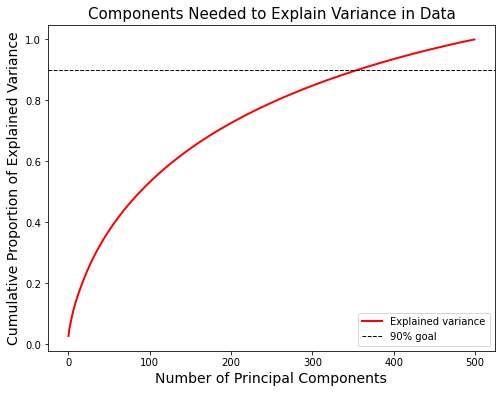

In [34]:
total_var = np.sum(fitted_pca.explained_variance_)
cum_var = np.cumsum(fitted_pca.explained_variance_)
prop_var_expl = cum_var/total_var

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
ax.axhline(.9, label = '90% goal', linestyle='--', color='black', linewidth=1)
ax.set_ylabel('Cumulative Proportion of Explained Variance', fontsize = 14)
ax.set_xlabel('Number of Principal Components', fontsize = 14)
ax.set_title('Components Needed to Explain Variance in Data', fontsize = 15)
ax.legend(loc = 'lower right', )

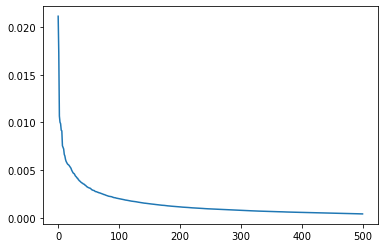

In [31]:
plt.plot(fitted_pca.explained_variance_)